In [20]:
import numpy as np
import glob
import random
import warnings
warnings.filterwarnings(action = 'ignore')
import matplotlib.pyplot as plt

from PIL import Image

random.seed(98)
np.random.seed(98)

In [21]:
import pandas as pd 
import numpy as np 
from tensorflow import keras
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten
from keras.models import Sequential 
import tensorflow as tf 

In [22]:
breast_img = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)

for img_name in breast_img[:3]:
    print(img_name)

/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png


In [23]:
neg_img = []
pos_img = []

for img in breast_img:
    if img[-5] == '0' :
        neg_img.append(img)
    
    elif img[-5] == '1' :
        pos_img.append(img)

In [24]:
neg_num = len(neg_img)
pos_num = len(pos_img)
        
total_img_num = neg_num + pos_num
        
print('Number of Images in IDC (-): {}' .format(neg_num))
print('Number of Images in IDC (+) : {}' .format(pos_num))
print('Total Number of Images : {}' .format(total_img_num))

Number of Images in IDC (-): 198738
Number of Images in IDC (+) : 78786
Total Number of Images : 277524


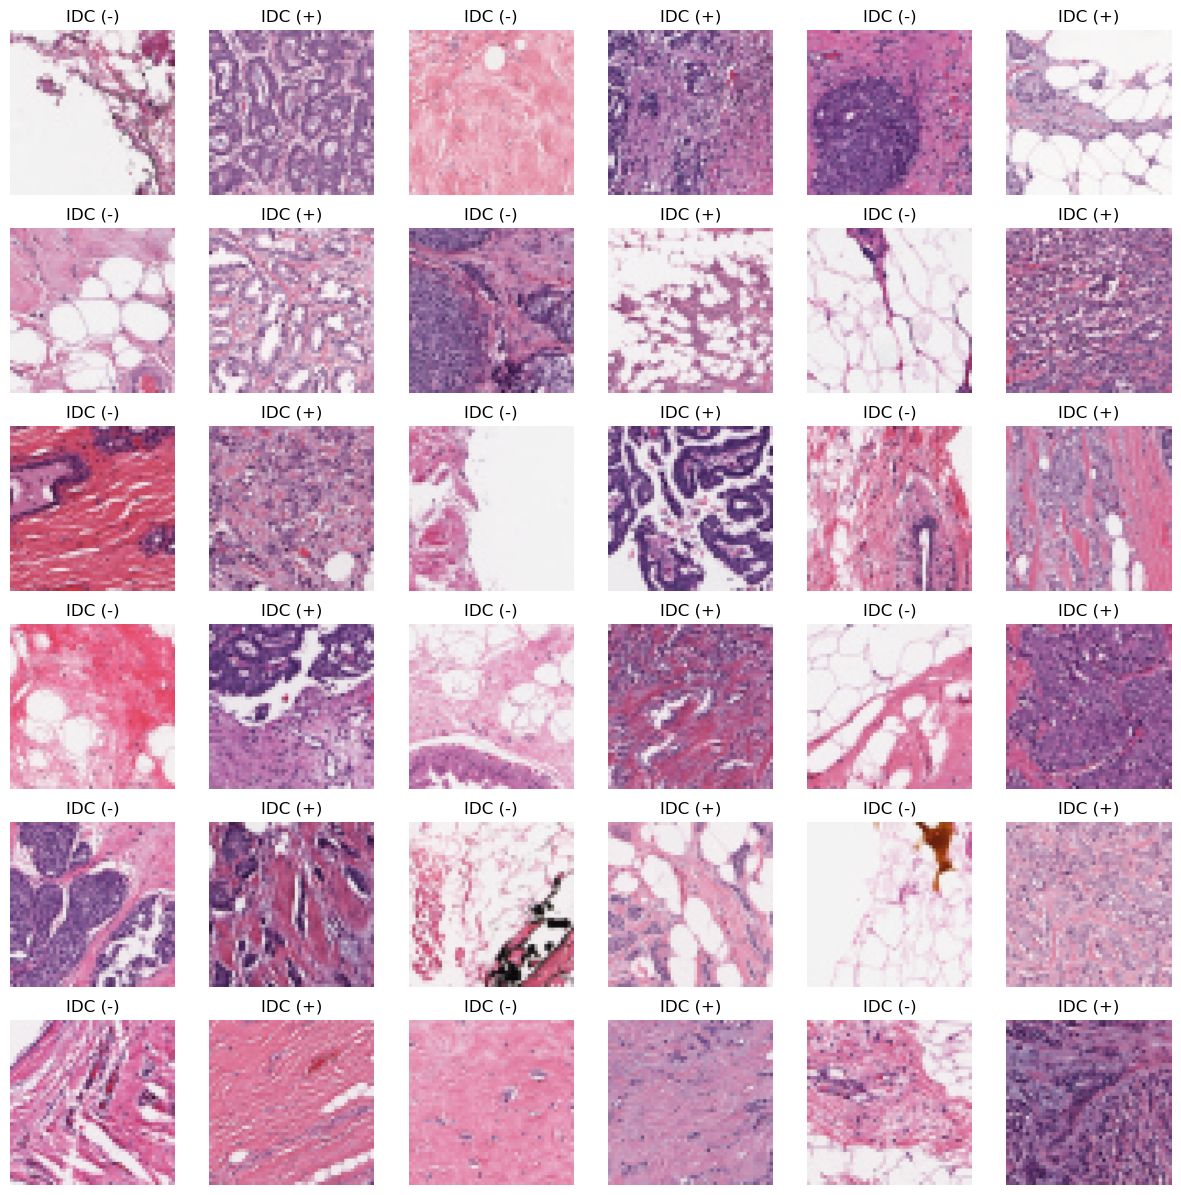

In [25]:
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

plt.figure(figsize = (15, 15))

some_neg = np.random.randint(0, len(neg_img), 18)
some_pos = np.random.randint(0, len(pos_img), 18)

s = 0
for num in some_neg:
    
        img = load_img((neg_img[num]), target_size=(100, 100))
        img = img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('IDC (-)')
        plt.imshow(img.astype('uint8'))
        s += 1
        
s = 1
for num in some_pos:
    
        img = load_img((pos_img[num]), target_size=(100, 100))
        img = img_to_array(img)
        
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1

In [26]:
from matplotlib.image import imread
import cv2

some_neg_img = random.sample(neg_img, len(pos_img))
some_pos_img = random.sample(pos_img, len(pos_img))

neg_img_arr = []
pos_img_arr = []

for img in some_neg_img:
        
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    neg_img_arr.append([n_img_size, 0])
    
for img in some_pos_img:
    
    p_img = cv2.imread(img, cv2.IMREAD_COLOR)
    p_img_size = cv2.resize(p_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    pos_img_arr.append([p_img_size, 1])

In [27]:
# create empty lists to hold features and labels 
X = []
y = []

# concatenate negative and positive image arrays and shuffle the resulting array randomly
breast_img_arr = np.concatenate((neg_img_arr, pos_img_arr))
random.shuffle(breast_img_arr)

# iterate over each breast image in the shuffled array
for feature, label in breast_img_arr:
    # add the image feature to the list of features
    X.append(feature)
    # add the label to the list of labels
    y.append(label)
    
# convert the list of features to a numpy array
X = np.array(X)
# convert the list of labels to a numpy array
y = np.array(y)

# print the shape of the feature array
print('X shape : {}' .format(X.shape))

X shape : (157572, 50, 50, 3)


In [28]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

X_train, X_predict, y_train, y_true = train_test_split(X, y, test_size = 0.3, random_state = 7)

rate = 0.5
num = int(X.shape[0] * rate)

X_test = X_train[num:]
X_train = X_train[:num]

y_test = y_train[num:]
y_train = y_train[:num]

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_true = to_categorical(y_true, 2)

print('X_train shape : {}' .format(X_train.shape))
print('X_test shape : {}' .format(X_test.shape))
print('X_predict shape : {}' .format(X_predict.shape))
print('y_train shape : {}' .format(y_train.shape))
print('y_test shape : {}' .format(y_test.shape))
print('y_true shape : {}' .format(y_true.shape))

X_train shape : (78786, 50, 50, 3)
X_test shape : (31514, 50, 50, 3)
X_predict shape : (47272, 50, 50, 3)
y_train shape : (78786, 2)
y_test shape : (31514, 2)
y_true shape : (47272, 2)


In [29]:
from tensorflow.keras.applications import VGG16

# Load the VGG16 model, excluding the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(50,50,3))

58889256/58889256 [==============================] - 1s 0us/step


In [30]:
for layer in base_model.layers:
    layer.trainable = False

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Create a new model on top of the pre-trained VGG16 model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

In [37]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 10, batch_size = 64)

Epoch 1/10
1232/1232 [==============================] - 34s 22ms/step - loss: 0.4672 - accuracy: 0.8698 - val_loss: 0.3039 - val_accuracy: 0.8869
Epoch 2/10
1232/1232 [==============================] - 26s 21ms/step - loss: 0.2911 - accuracy: 0.8875 - val_loss: 0.2896 - val_accuracy: 0.8869
Epoch 3/10
1232/1232 [==============================] - 22s 18ms/step - loss: 0.2811 - accuracy: 0.8918 - val_loss: 0.2826 - val_accuracy: 0.8902
Epoch 4/10
1232/1232 [==============================] - 22s 18ms/step - loss: 0.2751 - accuracy: 0.8939 - val_loss: 0.2844 - val_accuracy: 0.8917
Epoch 5/10
1232/1232 [==============================] - 26s 21ms/step - loss: 0.2721 - accuracy: 0.8958 - val_loss: 0.2807 - val_accuracy: 0.8922
Epoch 6/10
1232/1232 [==============================] - 22s 18ms/step - loss: 0.2676 - accuracy: 0.8972 - val_loss: 0.3052 - val_accuracy: 0.8871
Epoch 7/10
1232/1232 [==============================] - 22s 18ms/step - loss: 0.2660 - accuracy: 0.8986 - val_loss: 0.2856 -

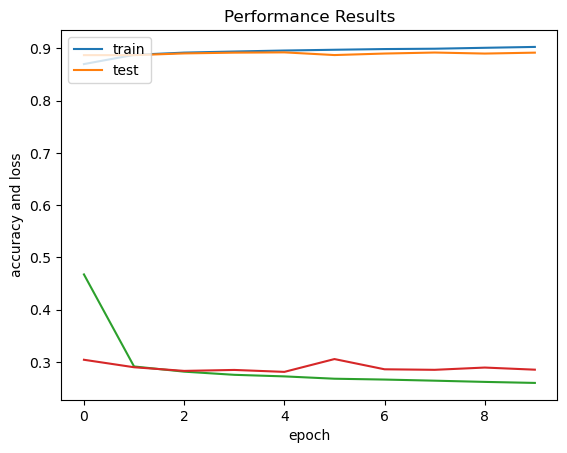

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Performance Results')
plt.xlabel('epoch')
plt.ylabel('accuracy and loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()